<a href="https://colab.research.google.com/github/dkalenov/ML-Trading/blob/1_unsupervised-learning/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Case Study

Traders who are particuarly keen on Pairs Trading, need a way to find pairs that:
    
    a) Are similar in risk and behaviour
    b) Are cointegrated

K-Means Clustering is a Clustering technique as to which a vast array of features can have their data compared with one another and grouped into clusters of similarity. The applications of this are vast as described in the theory sections of the course.

Once stocks/cryptocurrencies/FOREX pairs are grouped, they can then have cointegration calculations run against them to further help with statistical methods. Although cointegration is more a statistics method rather than Machine Learning, the code has been included here for convenience.

### Imports

In [229]:
# Remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data extraction and management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Feature Engineering
from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

### Data Extraction

In [285]:
# import yfinance as yf

# data = yf.download("BTC", "2017-01-01", "2024-03-28")
# data = data[["Open", "High", "Low", "Adj Close", "Volume"]]
# data.tail()

In [286]:
# Set Data Extraction parameters
start_date = "2017-01-01"
end_date = "2024-03-27"
file_name = "data/raw_data_etf.csv"
file_name_coint = "data/raw_data_coint_pairs.csv"
load_existing = True
load_coint_pairs = True

In [287]:
# Get New or Load Existing Data
# Allow 15 mins for new data
import os
import yfinance as yf

if not os.path.exists('data'):
    os.makedirs('data')

if not load_existing:
  symbols = get_nasdaq_symbols()
  symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
  symbols = list(symbols.index.values)
  data =yf.download(symbols, "2017-01-01", "2024-03-28")["Adj Close"]
  data.to_csv(file_name)

In [288]:
# Load (or re-load for consistency) Data and remove features with NaN's

url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/1_unsupervised-learning/raw_data_etf.csv'
data = pd.read_csv(url,  delimiter=',', encoding='utf-8', encoding_errors='ignore')


# data = pd.read_csv(file_name)
data.dropna(axis=1, inplace=True)
data = data.set_index("Date")
print("Shape: ", data.shape)
print("Null Values: ", data.isnull().values.any())
data.head()

Shape:  (1820, 258)
Null Values:  False


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,38.256813,48.610233,52.050144,33.607403,14.513459,18.454012,40.685699,23.448168,8.507782,20.096876,...,92.241486,39.782997,106.508606,49.461548,90.864632,55.448395,37.350456,42.318398,47.666119,25.109818
2017-01-04,38.915295,49.092216,52.495319,33.980911,14.513459,18.496130,40.903088,23.793995,8.627369,20.159475,...,93.301636,39.799175,108.744781,50.203377,92.239380,55.669300,37.762672,42.747505,48.091232,25.436157
2017-01-05,39.332634,49.784531,52.696091,34.271423,14.513459,18.492310,41.407421,23.390034,8.691715,20.208172,...,93.132347,39.847736,107.907433,49.702747,90.995972,56.025684,38.045570,43.161812,48.055809,25.520075
2017-01-06,39.202793,49.539143,52.704815,34.130314,14.513459,18.476995,41.233509,23.390034,8.775432,20.229038,...,93.372902,39.782997,107.355507,49.493393,90.505630,55.868900,37.964741,42.932453,48.055809,25.566696
2017-01-09,39.341915,49.582966,52.582603,34.080517,14.513459,18.431034,41.346550,22.897402,8.719054,20.242949,...,93.052177,39.807278,107.288902,49.161160,89.411079,56.011406,37.892002,42.814091,47.745827,25.629171


### Feature Engineering

In [289]:
# Create DataFrame with Returns and Volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.093457,0.223828
AAXJ,0.067449,0.206261
ACWI,0.121401,0.179920
ACWX,0.081153,0.179137
AGNG,0.118713,0.179965


In [290]:
# Scale Features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled = scaled_data
df_scaled.head()

,Returns,Volatility
AADR,0.019970,0.222306
AAXJ,-0.310375,0.036983
ACWI,0.374891,-0.240908
ACWX,-0.136314,-0.249167
AGNG,0.340750,-0.240433


### K-Means Clustering

In [291]:
df_clusters = df_scaled.copy()

In [292]:
!pip install kneed

#### Number of clusters

Find an optimal number of clusters


Optimum Clusters:  5



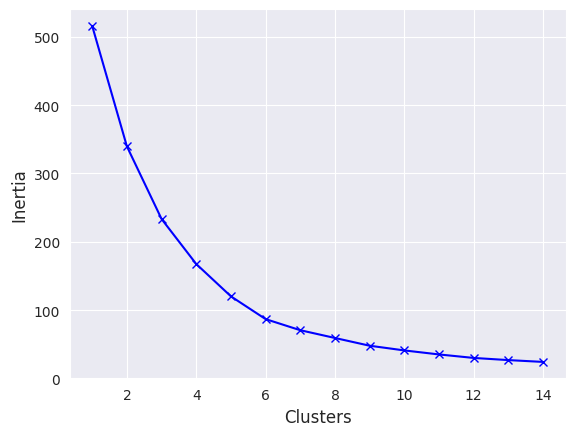

In [293]:
# Elbow method

from kneed import KneeLocator

# Find the optimum number of clusters
X = df_clusters.copy()
num_clusters = range(1, 15)
distortions = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

kl = KneeLocator(num_clusters, distortions, curve="convex", direction="decreasing")
clusters = kl.elbow
print("Optimum Clusters: ", clusters)
print()

# Plot the optimal number of clusters
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.plot([i for i in num_clusters], distortions, 'xb-')
plt.show()

<Axes: xlabel='cluster', ylabel='silhouette'>

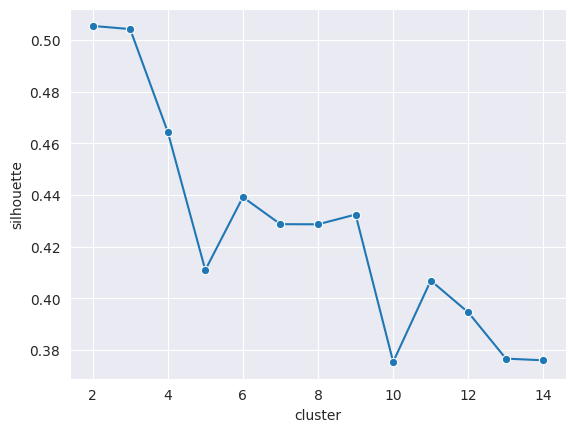

In [294]:
# Silhouette Score

from sklearn.metrics import silhouette_score
import seaborn as sns

# Find the optimum number of clusters using silhouette score
X = df_clusters.copy()

def get_silhouette(cluster_num, X):
     k_means = KMeans(n_clusters=cluster_num, random_state=42)
     k_means.fit(X)
     # calculate the silhouette metric by passing the data and which clusters the objects belong to
     silhouette = silhouette_score(X, k_means.predict(X))
     return silhouette

# create an empty dictionary, the keys will be inertia and the number of clusters
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 15):
     silhouette_res["silhouette"].append(get_silhouette(cluster_num, df_clusters))
     silhouette_res["cluster"].append(cluster_num)

# save the silhouette value and the number of clusters in a dataframe
silhouette_df = pd.DataFrame(silhouette_res)

# set the style for visualization
sns.set_style("darkgrid")
# visualize the dependence of the inertia value on the number of clusters
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

Elbow method demonstrates that the optimal number of clusters is 5.
Silhouette Score  demonstrates that the optimal number of clusters is 3 (then 4 or 6).

Let's choose 5 clusters

#### KMeans clustering

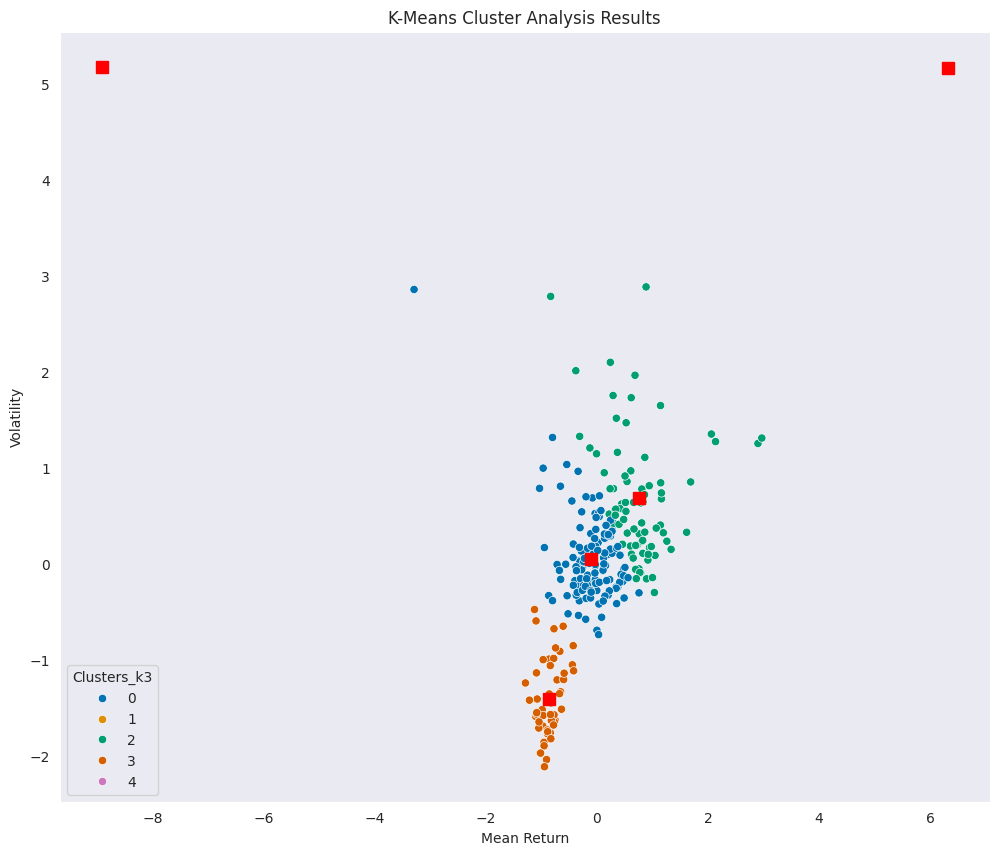

In [295]:
from sklearn.cluster import KMeans
import seaborn as sns

# initialize the k-means algorithm with the number of clusters 5
kmeans = KMeans(5, random_state=42)
# train and predict which cluster countries belong to
predictions = kmeans.fit_predict(df_clusters)

# Get class labels and centers
predictions = kmeans.labels_
centroids = kmeans.cluster_centers_

# save the predictions to a dataframe
df_clusters['Clusters_k3'] = predictions


# Create a scatter plot taking into account the color of the classes
fig  = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
#colors = ['blue', 'orange', 'red', 'green', 'black']
sns.scatterplot(x=df_clusters['Returns'], y=df_clusters['Volatility'], hue=df_clusters['Clusters_k3'], palette='colorblind')

# Remove the grid from the chart background
plt.grid(False)

# Add captions to the chart
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.plot(centroids[:,0], centroids[:,1], "sr", markersize=8) # "sr" - square red
plt.show()

3 & 4 clusters are outliers

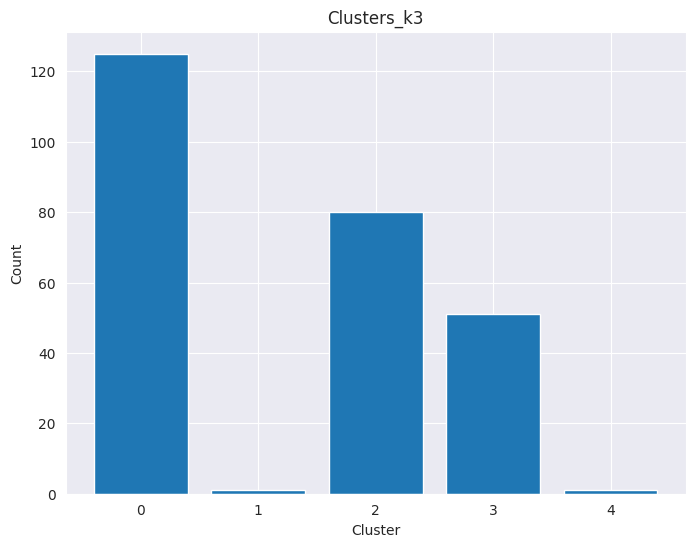

In [296]:
# Import the required module
import matplotlib.pyplot as plt

# Count the number of data points in each cluster for each clustering algorithm
cluster_k3_counts = df_clusters['Clusters_k3'].value_counts()

# Creating a figure with three subplots
fig = plt.figure(figsize=(8, 6))
# Bar plot for Clusters_k3
plt.bar(cluster_k3_counts.index, cluster_k3_counts.values)
plt.title('Clusters_k3')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### AgglomerativeClustering

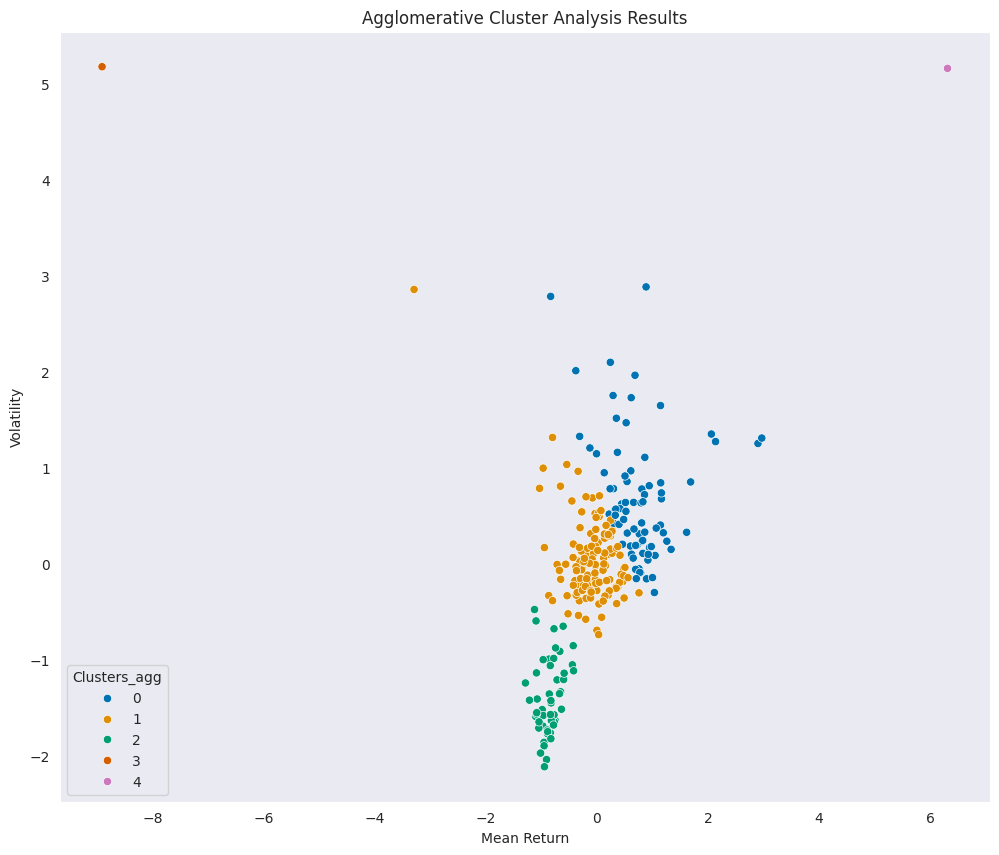

In [297]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(5, linkage='ward')
# determine which cluster the countries belong to
predictions = clustering.fit_predict(df_clusters)
# Get class labels
predictions = clustering.labels_
# save the predictions to a dataframe
df_clusters['Clusters_agg'] = predictions

# Create a scatter plot taking into account the color of the classes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
#colors = ['blue', 'orange', 'red', 'green', 'black']
sns.scatterplot(x=df_clusters['Returns'], y=df_clusters['Volatility'], hue=df_clusters['Clusters_agg'], palette='colorblind')

# Remove the grid from the chart background
plt.grid(False)

# Add captions to the chart
ax.set_title("Agglomerative Cluster Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")
plt.show()

It looks like KMeans clustering, but there is a difference in outliers. This model identify points of labels 1 & 3 like outliers

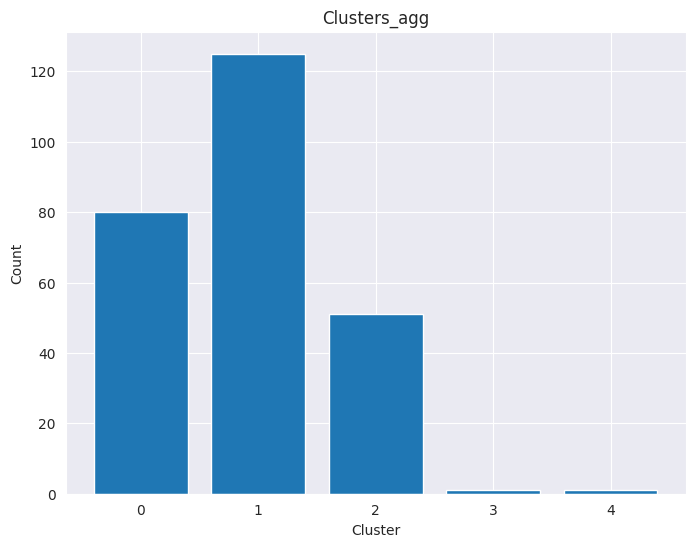

In [298]:
# Import the required module
import matplotlib.pyplot as plt

# Count the number of data points in each cluster for each clustering algorithm
cluster_agg_counts = df_clusters['Clusters_agg'].value_counts()

# Creating a figure with three subplots
fig = plt.figure(figsize=(8, 6))
# Bar plot for Clusters_agg
plt.bar(cluster_agg_counts.index, cluster_agg_counts.values)
plt.title('Clusters_agg')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### DBSCAN

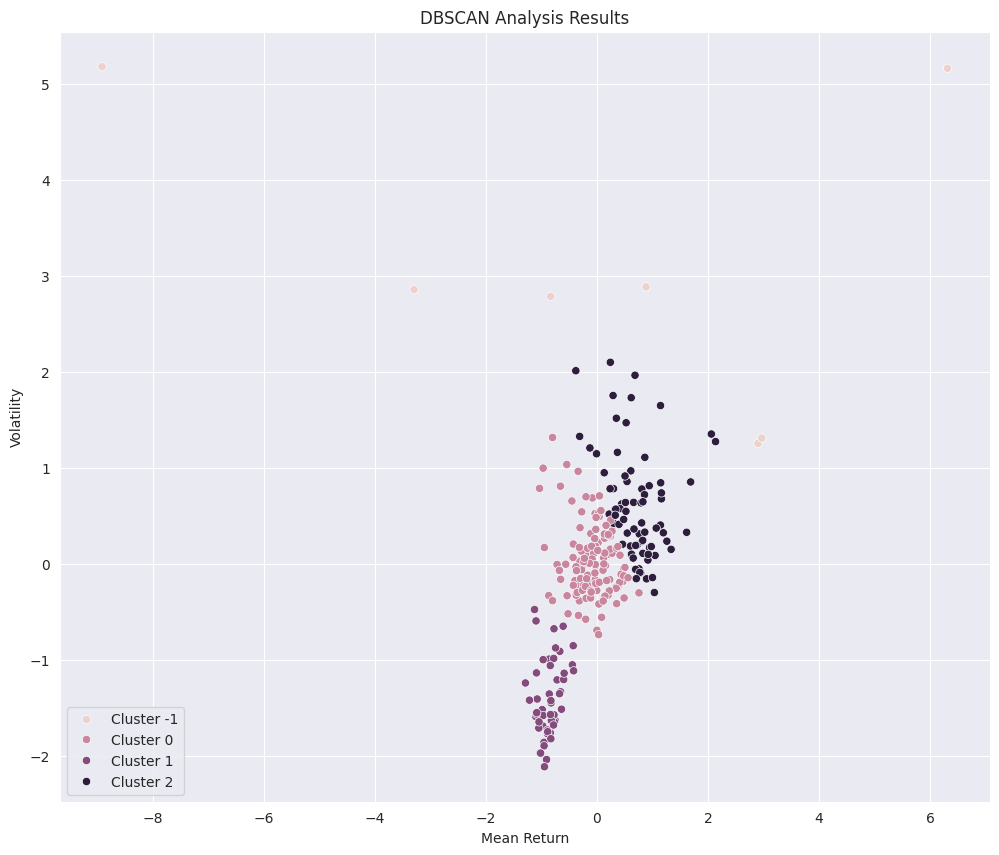

In [299]:
from sklearn.cluster import DBSCAN

# We start clustering on our data
dbscan = DBSCAN(eps=0.75, min_samples=5) # the 'eps' hyperparameter allows fine tuning of clustering

dbscan_pred = dbscan.fit_predict(df_clusters)
df_clusters['dbscan'] = dbscan_pred

# Create a graph
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
scatter = sns.scatterplot(x=df_clusters['Returns'], y=df_clusters['Volatility'], hue=dbscan_pred)

# Add captions to the graph
ax.set_title("DBSCAN Analysis Results")
ax.set_xlabel("Mean Return")
ax.set_ylabel("Volatility")

# Create a legend with matching colors and clusters
handles, labels = scatter.get_legend_handles_labels()
labels = ['Cluster ' + str(i) for i in labels]
ax.legend(handles, labels)

plt.show()

Cluster **label -1** represents *noise* or *outliers*. These are data points that do not belong to any specific cluster according to the algorithm.

! DBSCAN allows to fine-tune the clustering model, but requires careful analysis !

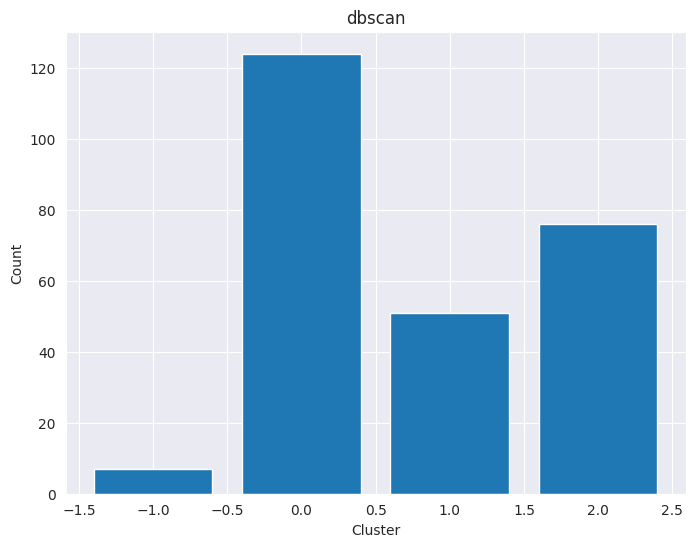

In [300]:
# Import the required module
import matplotlib.pyplot as plt

# Count the number of data points in each cluster for each clustering algorithm
cluster_dbscan_counts = df_clusters['dbscan'].value_counts()

# Creating a figure with three subplots
fig = plt.figure(figsize=(8, 6))
# Bar plot for dbscan
plt.bar(cluster_dbscan_counts.index, cluster_dbscan_counts.values)
plt.title('dbscan')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

#### Models' comparison

In [301]:
df_clusters.head(10)

,Returns,Volatility,Clusters_k3,Clusters_agg,dbscan
AADR,0.019970,0.222306,0,1,0
AAXJ,-0.310375,0.036983,0,1,0
ACWI,0.374891,-0.240908,0,1,0
ACWX,-0.136314,-0.249167,0,1,0
AGNG,0.340750,-0.240433,0,1,0
AGZD,-0.840880,-1.756043,3,2,1
AIA,-0.111978,0.316951,0,1,0
AIRR,1.160524,0.678572,2,0,2
ALTY,-0.397237,-0.173171,0,1,0
ANGL,-0.443085,-1.049061,3,2,1


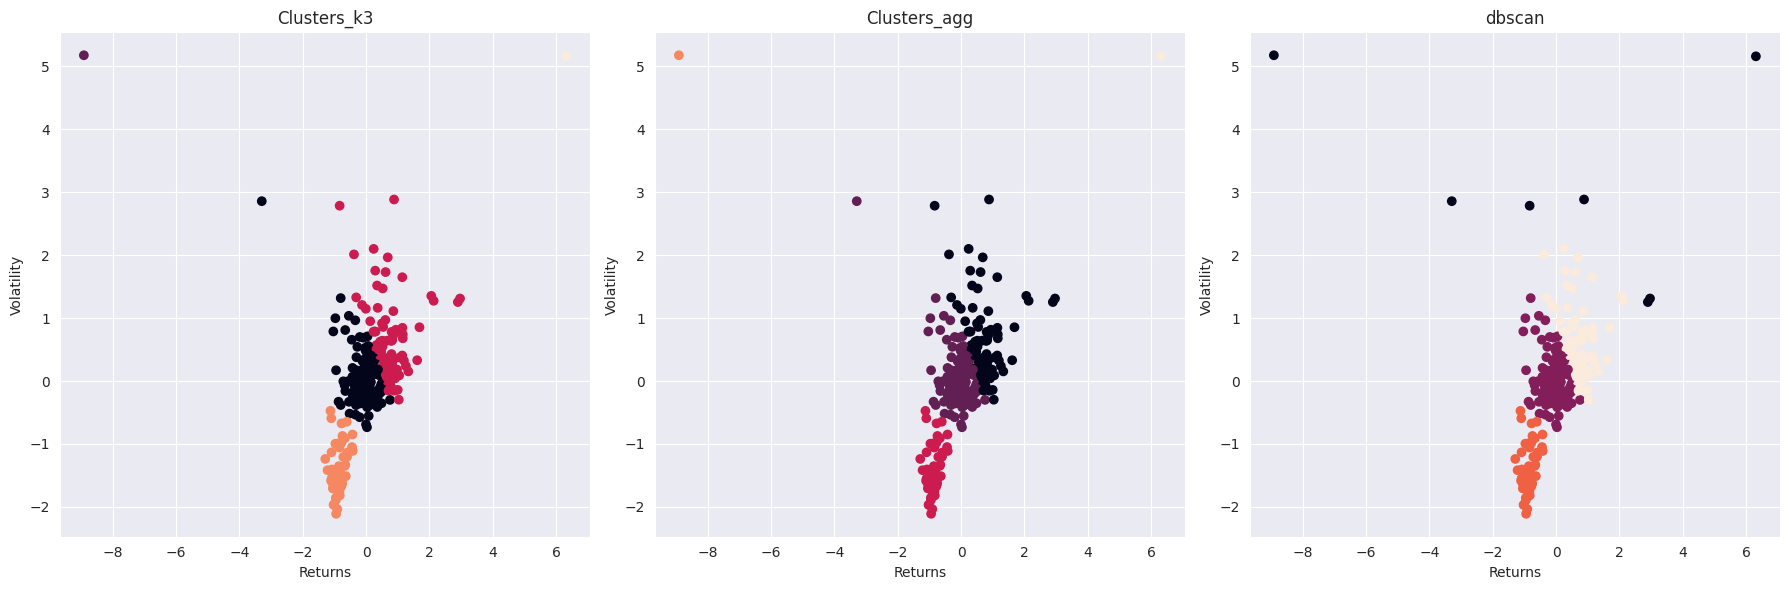

In [302]:
# Creating a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot with Clusters_k3
axes[0].scatter(df_clusters['Returns'], df_clusters['Volatility'], c=df_clusters['Clusters_k3'])
axes[0].set_title('Clusters_k3')
axes[0].set_xlabel('Returns')
axes[0].set_ylabel('Volatility')

# Scatter plot with Clusters_agg
axes[1].scatter(df_clusters['Returns'], df_clusters['Volatility'], c=df_clusters['Clusters_agg'])
axes[1].set_title('Clusters_agg')
axes[1].set_xlabel('Returns')
axes[1].set_ylabel('Volatility')

# Scatter plot with dbscan
axes[2].scatter(df_clusters['Returns'], df_clusters['Volatility'], c=df_clusters['dbscan'])
axes[2].set_title('dbscan')
axes[2].set_xlabel('Returns')
axes[2].set_ylabel('Volatility')

# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plots
plt.show()

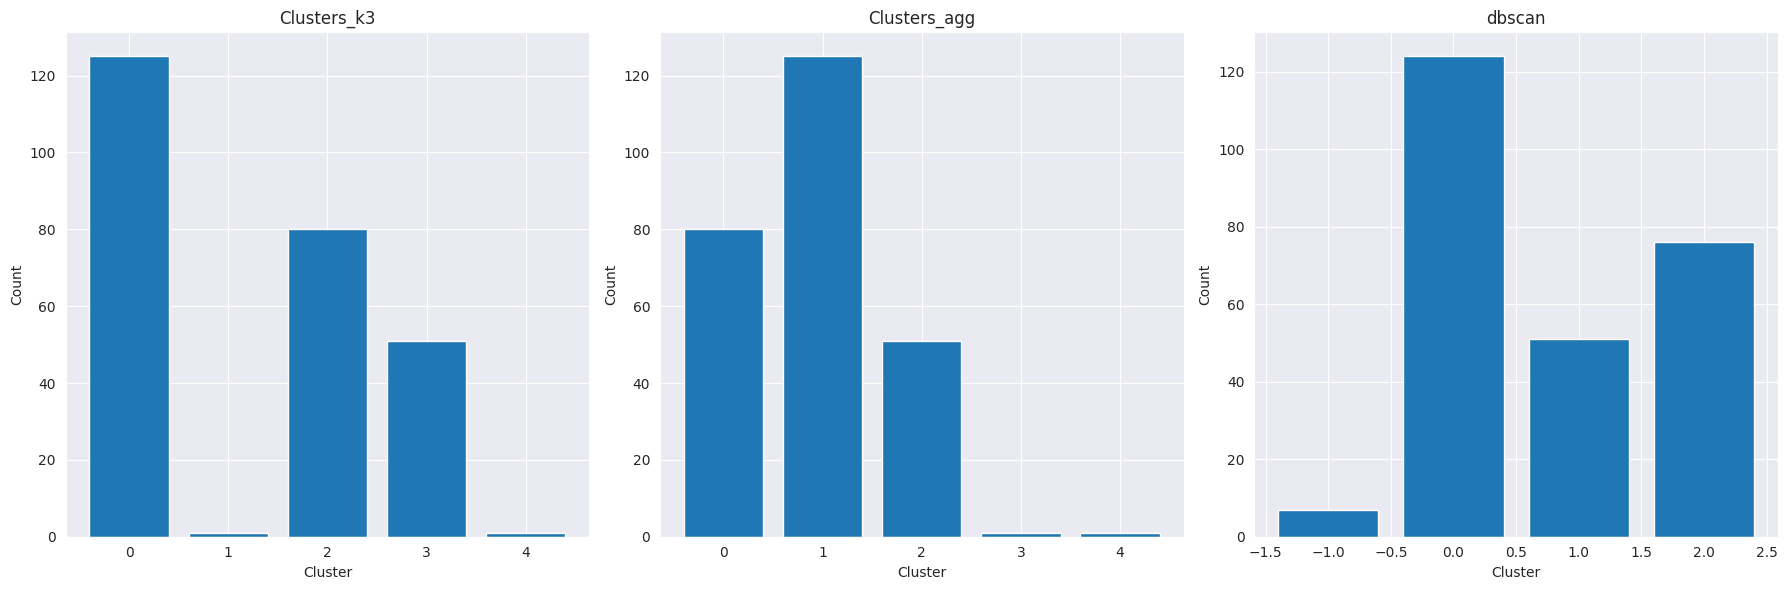

In [303]:
# Count the number of data points in each cluster for each clustering algorithm
cluster_k3_counts = df_clusters['Clusters_k3'].value_counts()
cluster_agg_counts = df_clusters['Clusters_agg'].value_counts()
dbscan_counts = df_clusters['dbscan'].value_counts()

# Creating a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot for Clusters_k3
axes[0].bar(cluster_k3_counts.index, cluster_k3_counts.values)
axes[0].set_title('Clusters_k3')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')

# Bar plot for Clusters_agg
axes[1].bar(cluster_agg_counts.index, cluster_agg_counts.values)
axes[1].set_title('Clusters_agg')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')

# Bar plot for dbscan
axes[2].bar(dbscan_counts.index, dbscan_counts.values)
axes[2].set_title('dbscan')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Count')

# Adjusting the spacing between subplots
plt.tight_layout()

# Displaying the plots
plt.show()

#### Removing outliers

##### KMeans

In [313]:
df_without_outliers = df_clusters.copy()
len(df_without_outliers)

258

In [314]:
# df_without_outliers[df_without_outliers['Clusters_k3'].values >= 3]
df_without_outliers[df_without_outliers['Clusters_k3'].isin([1, 4])]

,Returns,Volatility,Clusters_k3,Clusters_agg,dbscan
SQQQ,-8.912481,5.175944,1,3,-1
TQQQ,6.312431,5.159040,4,4,-1


In [315]:
# Remove Items if Preferred

df_without_outliers = df_without_outliers[df_without_outliers['Clusters_k3'].isin([0, 2, 3])]

len(df_without_outliers)

256

#####  AgglomerativeClustering

In [316]:
# df_without_outliers = df_scaled.copy()
# len(df_without_outliers)

In [317]:
# df_without_outliers[df_without_outliers['Clusters_agg'].isin([1, 3])]

In [318]:
# # Remove Items if Preferred

# df_without_outliers = df_without_outliers[df_without_outliers['Clusters_agg'].isin([0, 2, 4])]

# len(df_without_outliers)

##### dbscan

In [319]:
# df_without_outliers = df_scaled.copy()
# len(df_without_outliers)

In [320]:
# df_without_outliers[df_without_outliers['dbscan'] == -1]

In [321]:
# df_without_outliers = df_without_outliers[df_without_outliers['dbscan'].values > -1]
# len(df_without_outliers)

### Calculate Cointegration

In [322]:
df_without_outliers

,Returns,Volatility,Clusters_k3,Clusters_agg,dbscan
AADR,0.019970,0.222306,0,1,0
AAXJ,-0.310375,0.036983,0,1,0
ACWI,0.374891,-0.240908,0,1,0
ACWX,-0.136314,-0.249167,0,1,0
AGNG,0.340750,-0.240433,0,1,0
...,...,...,...,...,...
VWOB,-0.840640,-1.056925,3,2,1
VXUS,-0.114068,-0.277240,0,1,0
VYMI,-0.103799,-0.291981,0,1,0
WOOD,0.203085,0.306670,0,1,0


In [323]:
# Calculate cointegration
def calculate_cointegration(series_1, series_2):
    coint_flag = 0
    coint_res = coint(series_1, series_2)
    coint_t = coint_res[0]
    p_value = coint_res[1]
    critical_value = coint_res[2][1]
    model = sm.OLS(series_1, series_2).fit()
    hedge_ratio = model.params[0]
    coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0 # ' coint_t < critical_value ' It's worth experimenting with the inequality sign. There is no clear opinion what should be greater
    return coint_flag, hedge_ratio

In [324]:
# Loop through and calculate cointegrated pairs
# Allow 10 - 30 mins for calculation
tested_pairs = []
cointegrated_pairs = []

if not load_coint_pairs:
    for base_asset in df_without_outliers.index:
        base_label = df_without_outliers.loc[base_asset, "Clusters_k3"]

        for compare_asset in df_without_outliers.index:
            compare_label =  df_without_outliers.loc[compare_asset, "Clusters_k3"]

            test_pair = base_asset + compare_asset
            test_pair = ''.join(sorted(test_pair))
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            if compare_asset != base_asset and base_label == compare_label and not is_tested:

                series_1 = data[base_asset].values.astype(float)
                series_2 = data[compare_asset].values.astype(float)
                coint_flag, _ = calculate_cointegration(series_1, series_2)
                if coint_flag == 1:
                    cointegrated_pairs.append({"base_asset": base_asset,
                                               "compare_asset": compare_asset,
                                               "label": base_label})

    df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
    df_coint.to_csv(file_name_coint)

In [325]:
# Load Cointegrated Pairs

url = 'https://raw.githubusercontent.com/dkalenov/ML-Trading/1_unsupervised-learning/raw_data_coint_pairs.csv'
df_coint = pd.read_csv(url).iloc[:, 1:]

# df_coint = pd.read_csv(file_name_coint).iloc[:, 1:]
df_coint.head()

,base_asset,compare_asset,label
0,AADR,DGRE,0
1,FEP,PIE,0
2,FEP,RFDI,0
3,FEX,INDY,0
4,FID,FTGC,0


### TSNE Plot for Visualization

The **t-distributed Stochastic Neighbor Embedding (TSNE)** algorithm is a method for transforming high-dimensional data into a lower-dimensional space, typically two-dimensional or three-dimensional. It is commonly used for visualizing complex data and uncovering hidden structures.

In [326]:
# Get unique list of cointegrated assets
coint_assets = [df_coint["base_asset"].values]
coint_assets.append(df_coint["compare_asset"].values)
coint_unique_assets = np.unique(coint_assets)
coint_unique_assets[:5]

array(['AADR', 'AAXJ', 'ACWX', 'AGNG', 'AGZD'], dtype=object)

In [327]:
# Get TSNE only returns and volatility
df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coint_unique_assets)]
df_TSNE.head()

,Returns,Volatility
AADR,0.019970,0.222306
AAXJ,-0.310375,0.036983
ACWX,-0.136314,-0.249167
AGNG,0.340750,-0.240433
AGZD,-0.840880,-1.756043


- **learning_rate** determines the learning rate of the TSNE algorithm.
- **perplexity** determines the balance between maintaining local and global data structure.
- **random_state** defines the seed for initializing the random number generator, which allows you to reproduce the results.
- **n_jobs=-1** specifies to use all available processor cores to parallelize the algorithm.

In [328]:
# Compute TSNE
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)
X_tsne[:5]

array([[ -1.7747571,  12.106215 ],
       [-13.351697 ,  14.972848 ],
       [-18.504189 ,  32.55728  ],
       [ 24.622244 ,  27.065647 ],
       [-50.09325  ,  -8.963714 ]], dtype=float32)

In [330]:
df_clusters.head()

,Returns,Volatility,Clusters_k3,Clusters_agg,dbscan
AADR,0.019970,0.222306,0,1,0
AAXJ,-0.310375,0.036983,0,1,0
ACWI,0.374891,-0.240908,0,1,0
ACWX,-0.136314,-0.249167,0,1,0
AGNG,0.340750,-0.240433,0,1,0


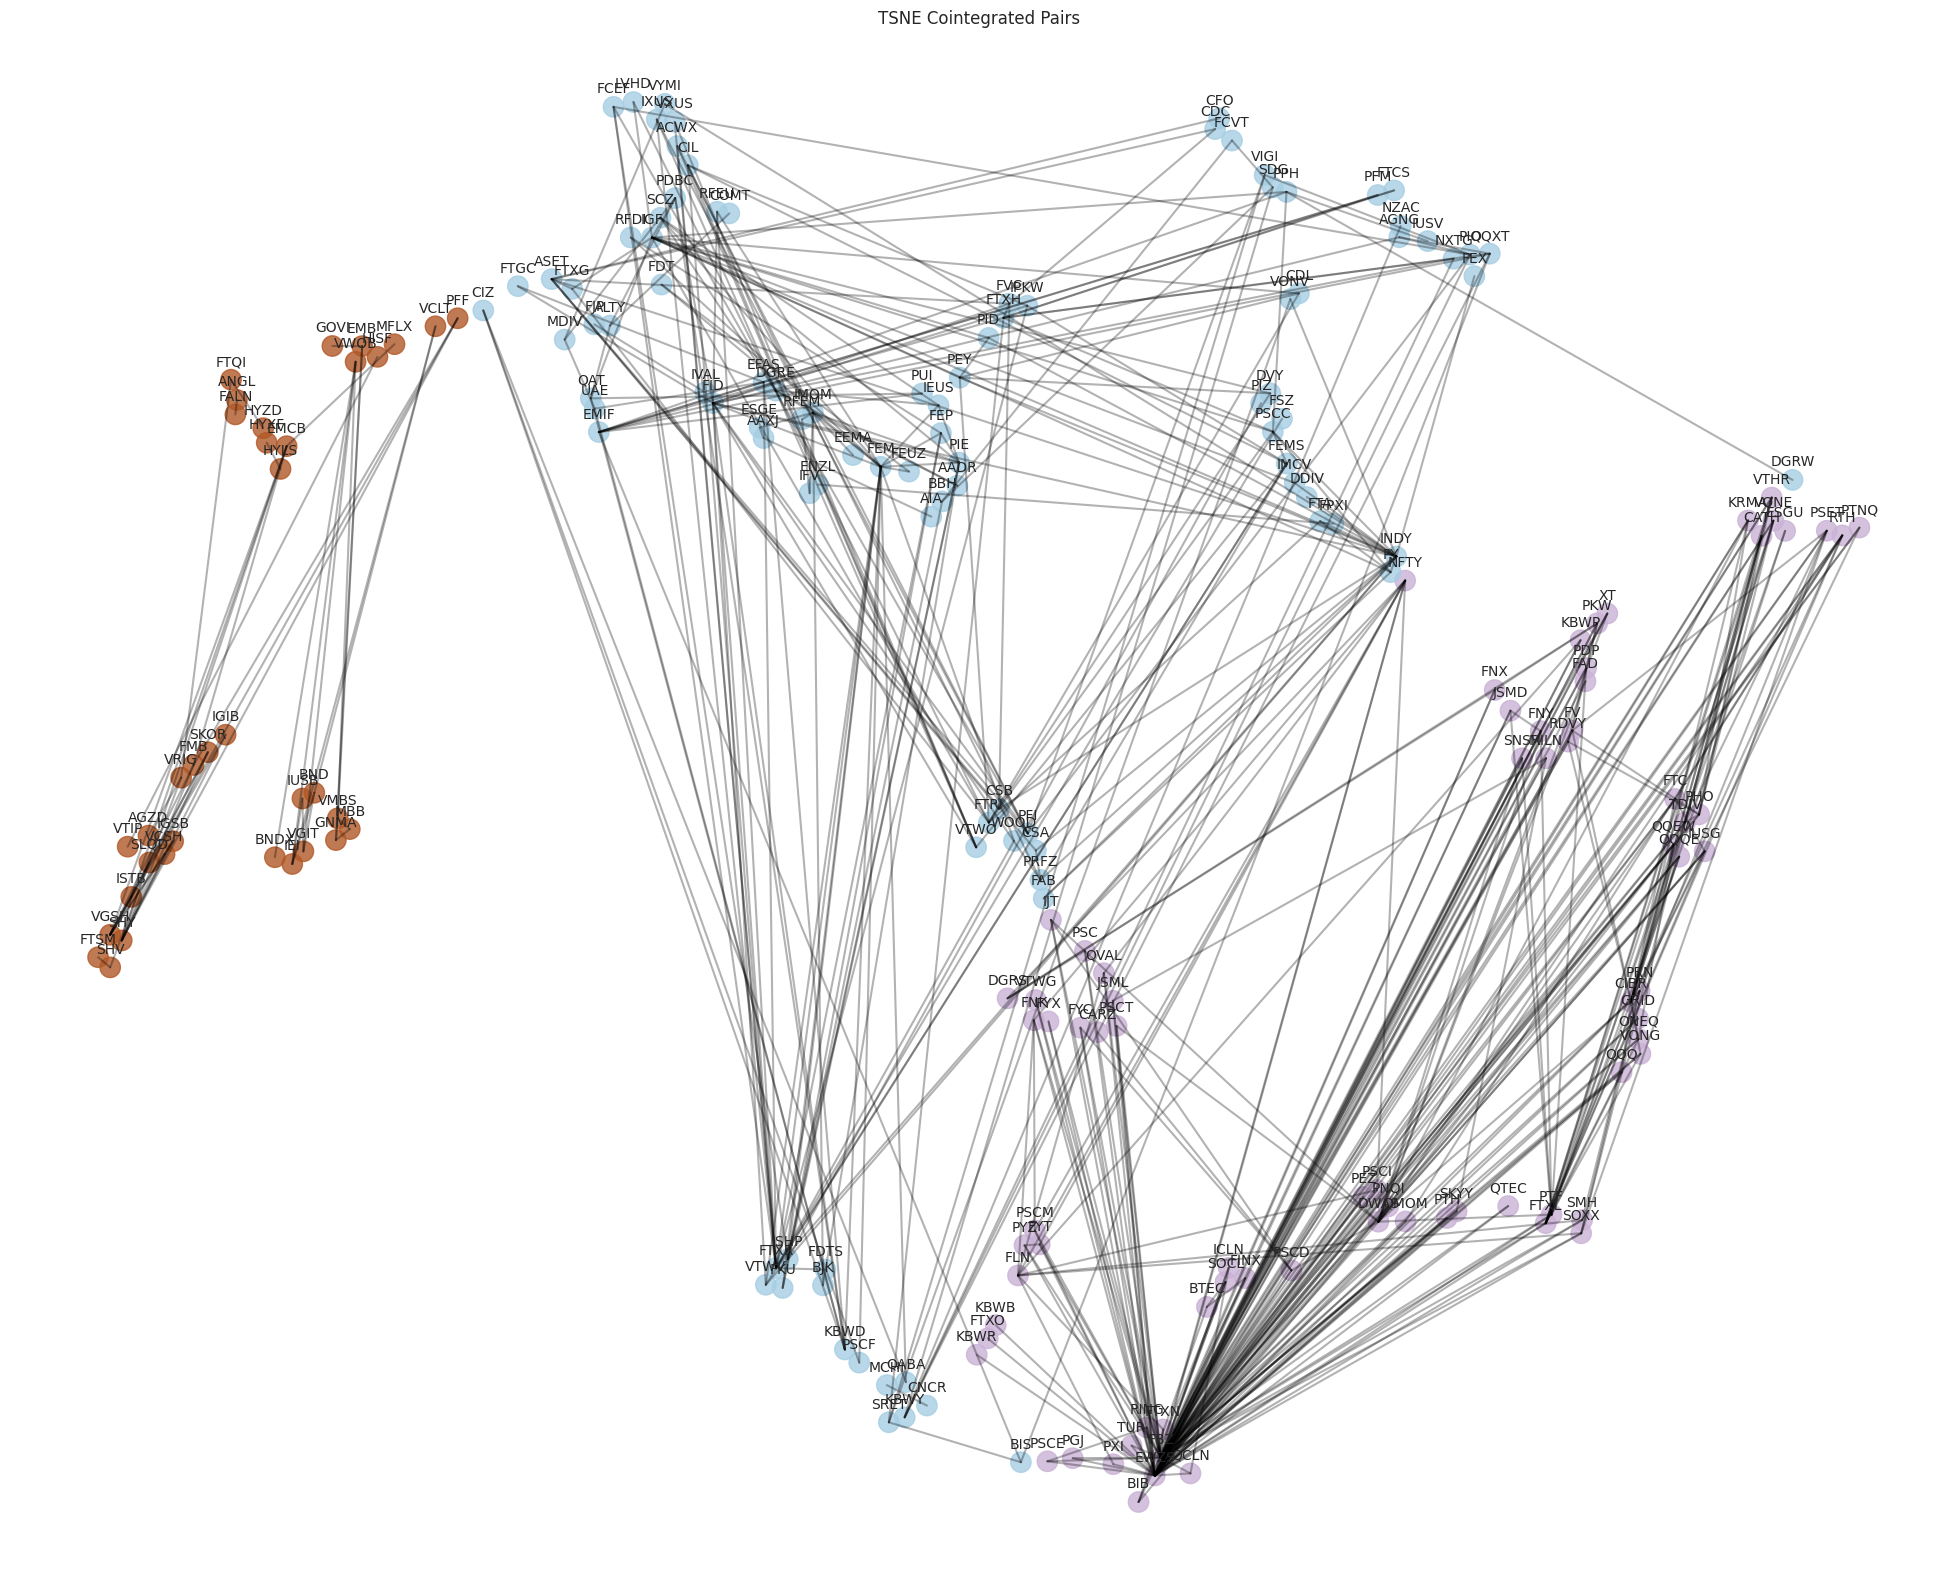

In [341]:
# Preview TSNE

# in_pairs_series = clustered_series.loc[coint_unique_assets]
in_pairs_series = df_without_outliers['Clusters_k3'].loc[coint_unique_assets]
plt.figure(1, figsize=(25, 20))
plt.clf()
plt.axis('off')
for index, pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Cointegrated Pairs')

# Show TSNE Plot
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    label = name
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha="center")
plt.show()

### Review a Pair

In [346]:
df_coint.head(5)

,base_asset,compare_asset,label
0,AADR,DGRE,0
1,FEP,PIE,0
2,FEP,RFDI,0
3,FEX,INDY,0
4,FID,FTGC,0


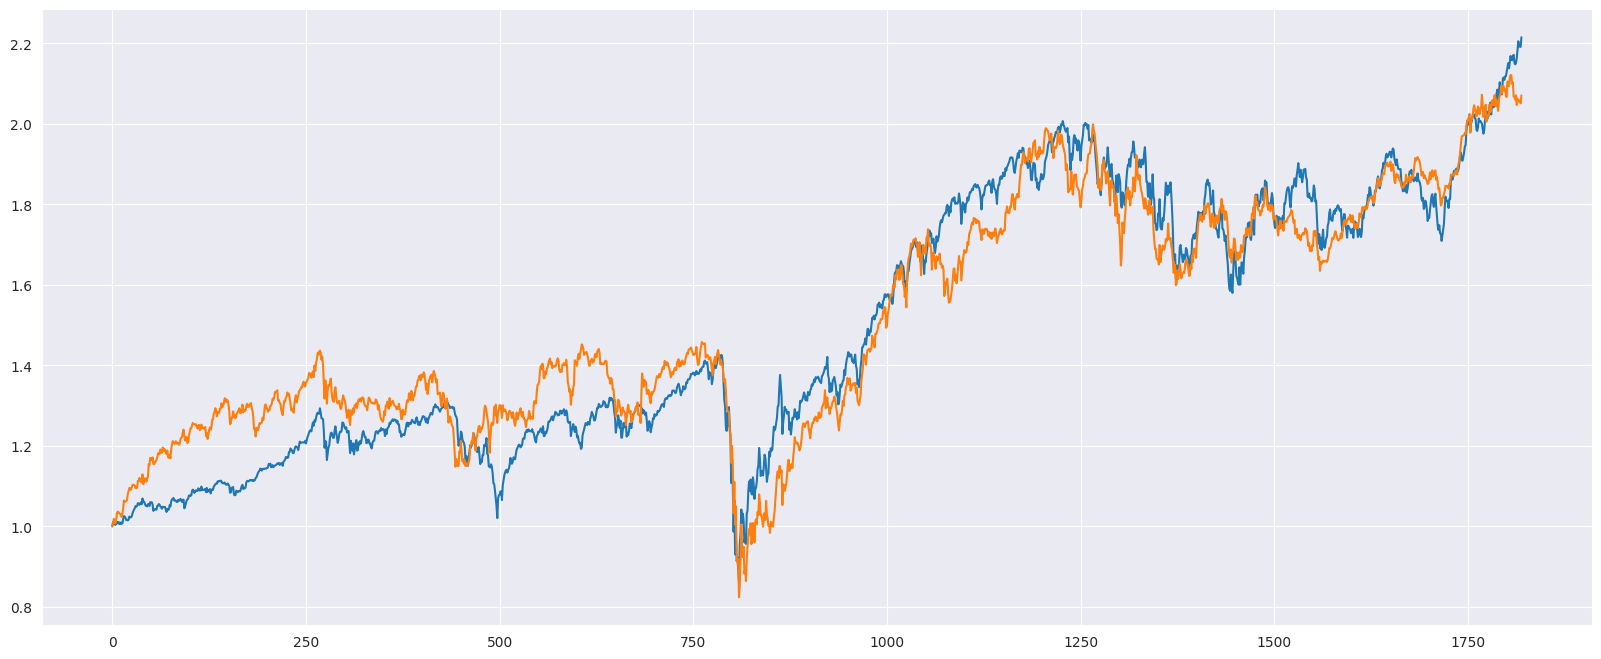

In [348]:
# Plot price comparison for any given assets
asset_1 = "FEX"
asset_2 = "INDY"
asset_1_values = data[asset_1].values / data[asset_1].iloc[0].item()
asset_2_values = data[asset_2].values / data[asset_2].iloc[0].item()
plt.figure(1, figsize=(20, 8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()

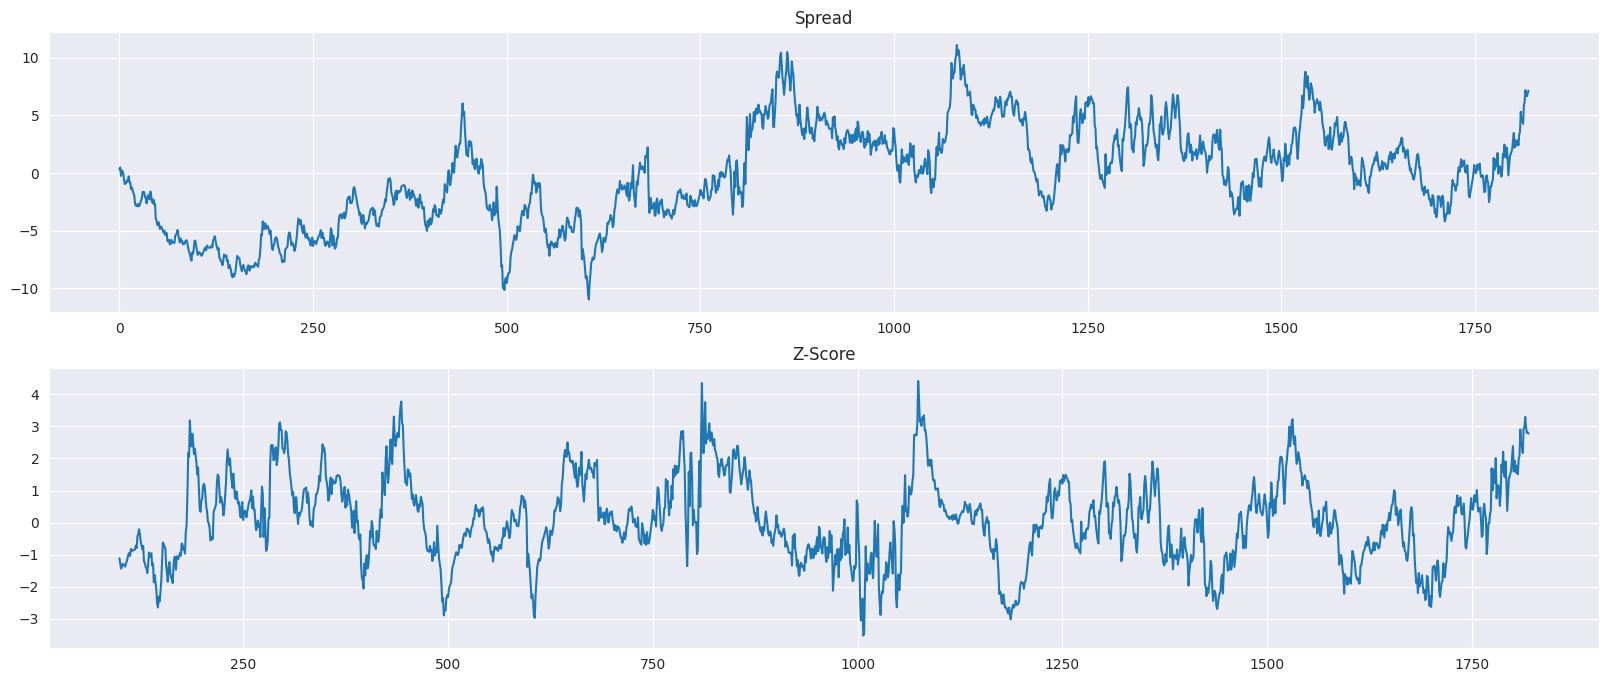

In [354]:
# Plot the Spread
series_1 = data[asset_1].values.astype(float)
series_2 = data[asset_2].values.astype(float)
coint_flag, hedge_ratio = calculate_cointegration(series_1, series_2)
spread = series_1 - (hedge_ratio * series_2)
plt.figure(1, figsize=(20, 8))
plt.subplot(211)
plt.plot(spread)
plt.title("Spread")


# Plot the ZScore
window = 100
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False, window=window).mean()
std = spread_series.rolling(center=False, window=window).std()
x = spread_series.rolling(center=False, window=1).mean()
z_score = (x - mean) / std
plt.subplot(212)
plt.plot(z_score)
plt.title("Z-Score")
plt.show()

### Save Data

In [355]:
# Save Data
capped = []
for z in z_score:
    z = 6 if z > 6 else z
    z = -6 if z <-6 else z
    capped.append(z)
df_save = data[[asset_1, asset_2]].copy()
df_save["Spread"] = spread
df_save["ZScore"] = capped
df_save.dropna(inplace=True)
df_save.columns = ["Asset1", "Asset2", "Spread", "ZScore"]
df_save.to_csv("data/pair_trade.csv")
df_save.head()

,Asset1,Asset2,Spread,ZScore
Date,,,,
2017-05-25,48.097412,29.693655,-6.280692,-1.110035
2017-05-26,48.097412,29.914389,-6.684922,-1.270989
2017-05-30,48.042702,30.108637,-7.095360,-1.435276
2017-05-31,48.115646,30.108637,-7.022415,-1.377907
2017-06-01,48.635384,30.302879,-6.858395,-1.284590


### Conclusion

When sifting through heavy amounts of price data, it can be tricky to find potentially great pairs to trade quickly. Equally, having pairs which match likeness in terms of price behaviour including volatility, might be advantageous and ensure better risk management.

By clustering using K-Means, we have been able to quickly identify a list of trading pairs which resemble a likeness in respect to returns versus volatility. Helping to refine our conintegrated statistical arbitrage trading strategy even further.

It can help to automate the hunt for potentially great trading opportunities.

### References and Useful Material

Heavily influenced by *Igor Radovanovic* - Last Updated on July 16, 2022
https://algotrading101.com/learn/cluster-analysis-guide/

*Shaun McDonogh* - Statistical Arbitrage Course
https://www.udemy.com/course/statistical-arbitrage-bot-build-in-crypto-with-python-a-z/